In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from Deep_Learning.Representation_Learning.Utils.functional import cosine_schedule
import math

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

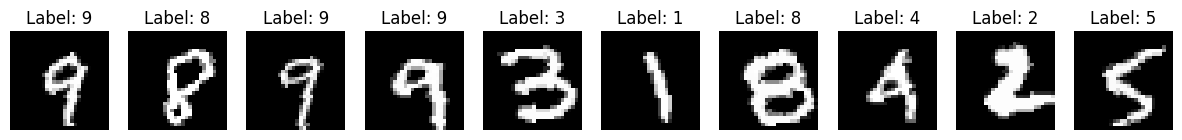

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [117]:
H_DIM = 128
NUM_CLASSES = 64
Z_DIM = 256
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, H_DIM, kernel_size=3, stride=1),
            nn.BatchNorm2d(H_DIM),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.classify = nn.Sequential(
            nn.Linear(H_DIM, NUM_CLASSES),
            nn.BatchNorm1d(NUM_CLASSES),
            nn.Softmax(dim=1)
        )

        self.mu = nn.Embedding(NUM_CLASSES, Z_DIM)
        self.logVar = nn.Embedding(NUM_CLASSES, Z_DIM)

        self.z2h = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (H_DIM, 1, 1)),

            nn.ConvTranspose2d(H_DIM, 512, 3, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, 1, 1),
        )
        

    def encode(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        std = torch.exp(self.logVar.weight / 2)
        eps = torch.randn_like(std)
        samples = self.mu.weight + std * eps

        features = self.encoder(x)
        class_probs = self.classify(features)

        # sample z samples from the distribution
        if self.training:
            idx = torch.multinomial(class_probs, 1).squeeze()
        else:
            idx = torch.argmax(class_probs, dim=1)
        z = samples[idx]

        # through grad
        z = z.detach() + (class_probs @ samples.detach()) - (class_probs @ samples).detach()

        mu, logVar = self.mu.weight[idx], self.logVar.weight[idx]

        return z, mu, logVar


    def decode(self, z):

        h = self.z2h(z)
        x_hat = self.decoder(h)
        return x_hat
    
    def reconstruct(self, x):
        z = self.encoder(x)
        x_hat = self.decode(z)
        return x_hat

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        z, mu, logVar = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, mu, logVar

model = VAE().to(device)
x = torch.randn(10, 1, 28, 28).to(device)
model(x)[0].shape

torch.Size([10, 1, 28, 28])

In [129]:
mu = nn.Embedding(5, 4)
logvar = nn.Embedding(5, 4)

eps = torch.randn(5, 4)
samples = mu.weight + torch.exp(logvar.weight / 2) * eps

sample = samples[[0, 0, 1]]

layer = nn.Linear(4, 4)
with torch.no_grad():
    sample = layer(sample)


sample.mean().backward()
mu.weight.grad


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [118]:
def loss_fn(recon_x, x, mu, log_var, beta):
    recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, reduction="sum")
    mse = F.mse_loss(F.sigmoid(recon_x), x) * x.shape[0]
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (recon_loss + beta*kld), mse

def train(
        model,
        train_set,
        val_set,
        optimizer,
        lrs,
        batch_size,
        beta,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_mses = []
    val_losses = []
    val_mses = []
    mu_sims = []
    var_sims = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(len(lrs)):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        train_mse = 0 

        for param_group in optimizer.param_groups:
            param_group['lr'] = lrs[epoch].item()

        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{len(lrs)}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], train_mse=train_mses[-1], val_mse=val_mses[-1])#, mu_sim=mu_sims[-1], var_sim=var_sims[-1])

            with torch.cuda.amp.autocast():
                decoded, mu, log_var = model(x)
                loss, mse = loss_fn(decoded, x, mu, log_var, beta)
                # loss += (F.normalize(model.mu.weight) @ F.normalize(model.mu.weight).t()).triu(diagonal=1).mean() * 10000.0
                # loss += (F.normalize(model.logVar.weight) @ F.normalize(model.logVar.weight).t()).triu(diagonal=1).mean() * 100.0
                # loss /= len(x)

            train_loss += loss.item()
            train_mse += mse.item()
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # check 
        # mu_similarity = (F.normalize(model.mu.weight) @ F.normalize(model.mu.weight).t()).triu(diagonal=1)
        # var_similarity = (F.normalize(model.logVar.weight) @ F.normalize(model.logVar.weight).t()).triu(diagonal=1)
        
        train_losses.append(train_loss / len(train_set))
        train_mses.append(train_mse / len(train_set))
        # mu_sims.append(mu_similarity.mean().item())
        # var_sims.append(var_similarity.mean().item())


        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mse = 0
            for x, _ in val_loader:
                decoded, mu, log_var = model(x)

                loss, mse = loss_fn(decoded, x, mu, log_var, beta)
                # loss /= len(x)
                val_loss += loss.item()
                val_mse += mse.item()

            val_losses.append(val_loss / len(val_set))
            val_mses.append(val_mse / len(val_set))
        
    return train_losses, val_losses, train_mses, val_mses

In [119]:
EPOCHS = 10
BATCH_SIZE = 1000
BETA = 0.75

base_lr = 3e-4
end_lr = 1e-6
warm_up_lrs = torch.linspace(0, base_lr, 10)
cosine_lrs = cosine_schedule(base_lr, end_lr, EPOCHS-10)
lrs = torch.cat([warm_up_lrs, cosine_lrs])

model = VAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)

train_losses, val_losses, train_mses, val_mses = train(model, train_set, val_set, optimizer, lrs, BATCH_SIZE, BETA)

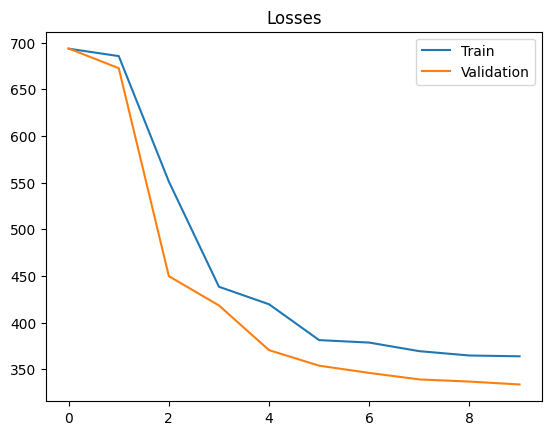

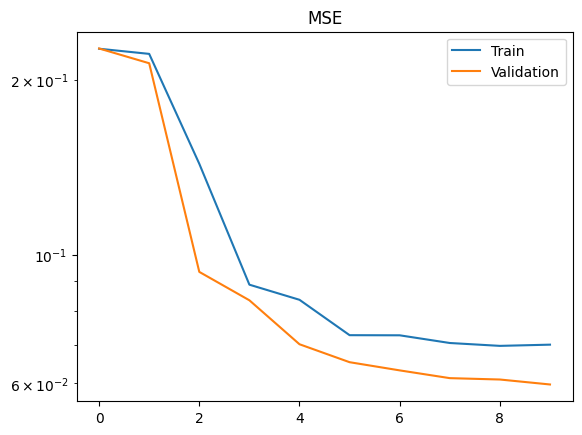

In [114]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')
plt.show()
# Plot mses
plt.plot(train_mses, label='Train')
plt.plot(val_mses, label='Validation')
plt.legend()
plt.title('MSE')
plt.yscale('log')
plt.show()

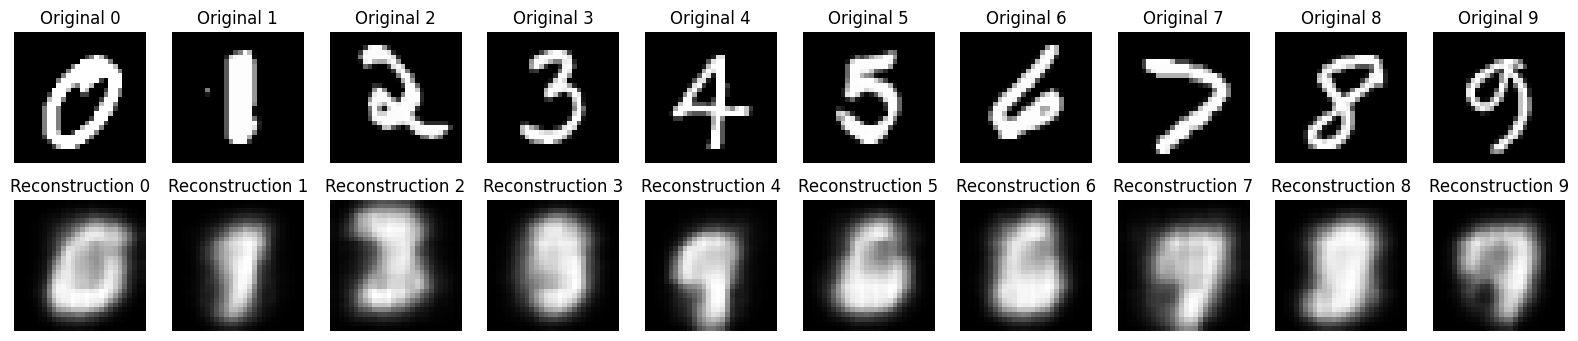

In [115]:
# Collect 1 image per class
model.eval()
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = F.sigmoid(x_hat.squeeze(0))

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [203]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(256, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler()

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            with torch.cuda.amp.autocast():
                mu, _, _ = model.encode(x)
                # mu = model.classify(model.encoder(x))
                pred = classifier(mu.detach())
                loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()

            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            with torch.cuda.amp.autocast():
                mu, _, _ = model.encode(x)
                # mu = model.classify(model.encoder(x))
                pred = classifier(mu.detach())
                loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [204]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

KeyboardInterrupt: 